In [572]:
import numpy as np
from random import seed
from random import random
import matplotlib.pyplot as plt
import math

def TextToArray(fileName):
    f_array=[]
    f = open(fileName, 'r+')
    lines = np.array([line for line in f.readlines()])
    for line in lines:
        line=line.replace('  ',',')
        for i in range(len(line)):
            if line[i]==',':
                first=float(line[:i])
                second=float(line[i+1:])
                f_array.append([first,second])
    return np.array(f_array)

Train1_f=TextToArray('Train1.txt')
Train2_f=TextToArray('Train2.txt')
Test1_f=TextToArray('Test1.txt')
Test2_f=TextToArray('Test2.txt')

#split train and validation
class1_train=Train1_f[0:1500]
class2_train=Train2_f[0:1500]
class1_val=Train1_f[1500:2000]
class2_val=Train2_f[1500:2000]

def mean_std(VecArray):
    mean = np.mean(VecArray, axis=0)
    std = np.std(VecArray, axis=0)
    result=np.vstack((mean,std))
    return result

#feature normalization
def normalize(x,mean,std):
    return (x-mean)/std

class1_train_ms=mean_std(class1_train)
class2_train_ms=mean_std(class2_train)

def updateVec(train_vec,train_vec_ms):
    for i in range(train_vec.shape[1]):
        for j in range(train_vec.shape[0]):
            mean=train_vec_ms[:,i][0]
            std=train_vec_ms[:,i][1]
            train_vec[:,i][j]=normalize(train_vec[:,i][j],mean,std)
    return train_vec

#normalize training data
norm_class1_train=updateVec(class1_train,class1_train_ms)
norm_class2_train=updateVec(class2_train,class2_train_ms)

#normalize validation data
norm_class1_val=updateVec(class1_val,class1_train_ms)
norm_class2_val=updateVec(class2_val,class2_train_ms)

#normalize testing data
norm_class1_test=updateVec(Test1_f,class1_train_ms)
norm_class2_test=updateVec(Test2_f,class2_train_ms)

In [573]:
#combine all train, val, test dataset
train_all=np.vstack((norm_class1_train,norm_class2_train))
val_all=np.vstack((norm_class1_val,norm_class2_val))
test_all=np.vstack((norm_class1_test,norm_class2_test))

In [574]:
#create labels
train_label=np.array([0] * 1500 + [1] * 1500)
val_label=np.array([0] * 500 + [1] * 500)
test_label=np.array([0] * 1000 + [1] * 1000)

In [575]:
# degin to design MLP network
class MLP():
    def __init__(self, input_nodes, output_nodes, lr=0.001):
        self.weight  = np.random.uniform(-(1/math.sqrt(input_nodes)), 
                                         1/math.sqrt(input_nodes), 
                                         (input_nodes, output_nodes))
        self.biase = np.zeros(output_nodes)
        self.lr = lr

    def forward(self, input):
        forward_output=np.dot(input, self.weight) + self.biase
        return forward_output

    def backward(self, input, loss_gradient):
        input_grad = np.dot(loss_gradient, self.weight.T)
        self.weight -= self.lr * (np.dot(input.T, loss_gradient))
        self.biase -= self.lr * (loss_gradient.mean(axis=0) * input.shape[0])
        return input_grad

In [576]:
def To_forward(network, input):
    activations = []
    for i in network:
        activations.append(i.forward(input))
        input = activations[-1]
    return activations

# use batch training
def batch_train(dataset, ground_truth, b_s):
    index = np.random.permutation(len(dataset))
    for i in range(0, len(dataset)-b_s+1, b_s):
        yield dataset[index[i:i+b_s]], ground_truth[index[i:i+b_s]]

In [577]:
# design the relu as activation function
class relu_activation():
    def forward(self, input):
        true_input=np.maximum(0, input)
        return true_input
    
    def backward(self, input, loss_gradient):
        return loss_gradient * (input>0)

In [578]:
def train_getloss(network, dataset, ground_truth, controller=True):
    activations = To_forward(network, dataset)
    logits = activations[-1]
    inputs = [dataset] + activations
    loss = np.mean(np.square(logits.T.squeeze() - ground_truth))
    if controller==True:
        loss_gradient = logits - np.array([ground_truth]).T  
        for index in range(len(network))[::-1]:
            layer = network[index]
            loss_gradient = layer.backward(inputs[index], loss_gradient)
    return loss

In [579]:
def get_acc(network, dataset, ground_truth):
    total_result=(To_forward(network, dataset)[-1] >= 0.5).T.squeeze() == ground_truth
    return np.mean(total_result)

Classification accuracy for testing test with 2 hidden nodes is 0.571.
Classification accuracy for testing test with 4 hidden nodes is 0.6575.
Classification accuracy for testing test with 6 hidden nodes is 0.6875.
Classification accuracy for testing test with 8 hidden nodes is 0.716.
Classification accuracy for testing test with 10 hidden nodes is 0.7225.
 
The highest classification accuracy for testing test is 0.7225 with 10 nodes.


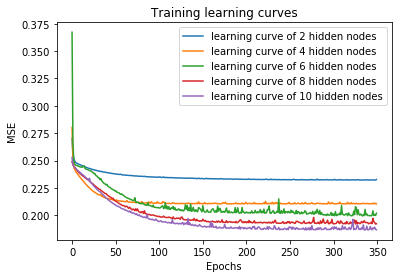

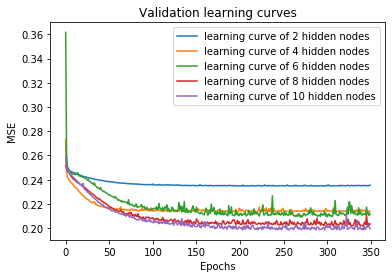

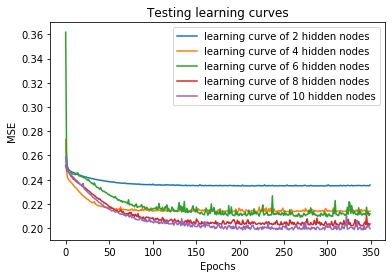

In [581]:
train_fig, train_ax = plt.subplots()
val_fig, val_ax = plt.subplots()
test_fig, test_ax = plt.subplots()

# five different number of hidden_nodes. 
BS=128
start, end = 2, 10
h_n=[]
for num in range(start, end + 1): 
    if num % 2 == 0:
        h_n.append(num)
#Get train, val ,test loss info.
save_acc={}
for i in h_n:
    train_info = list()
    val_info = list()
    test_info = list()
    network = list()
    network.append(MLP(norm_class1_train.shape[1], i))
    network.append(relu_activation())
    network.append(MLP(i, 1))
    network.append(relu_activation())
    prev_val_loss = math.inf
    # plot the result
    for j in range(350):
        for dataset, label_batch in batch_train(train_all, train_label, BS):
            train_getloss(network, dataset, label_batch, controller=True)
        train_info.append(train_getloss(network, 
                              train_all, 
                              train_label, 
                              controller=False))
        #  Train the network for the validation set no longer decreases. 
        if train_getloss(network, val_all, val_label, controller=False) >= prev_val_loss:
            pass
        else:
            prev_val_loss = train_getloss(network, val_all, val_label, controller=False) 
        val_info.append(train_getloss(network, 
                            val_all, 
                            val_label, 
                            controller=False))
        test_info.append(train_getloss(network, 
                             test_all, 
                             test_label, 
                             controller=False))            
# Plot learning Curve for train, validation, test
    train_ax.plot(range(350), 
             train_info, 
             label= f'learning curve of {i} hidden nodes' )
    train_ax.set_title("Training learning curves")
    train_ax.set_xlabel("Epochs")
    train_ax.set_ylabel("MSE")
    train_ax.legend()

    val_ax.plot(range(350), 
             val_info, 
             label= f'learning curve of {i} hidden nodes' )
    val_ax.set_title("Validation learning curves")
    val_ax.set_xlabel("Epochs")
    val_ax.set_ylabel("MSE")
    val_ax.legend()

    test_ax.plot(range(350), 
             val_info, 
             label= f'learning curve of {i} hidden nodes' )
    test_ax.set_title("Testing learning curves")
    test_ax.set_xlabel("Epochs")
    test_ax.set_ylabel("MSE")
    test_ax.legend()

    test_accuracy = get_acc(network, test_all,test_label)
    save_acc[i]=test_accuracy
    print(f"Classification accuracy for testing test with {i} hidden nodes is {test_accuracy}.")
    
max_key = max(save_acc, key=save_acc.get)
print(" ")
print("The highest classification accuracy for testing test is",save_acc[max_key],"with",max_key,"nodes.")

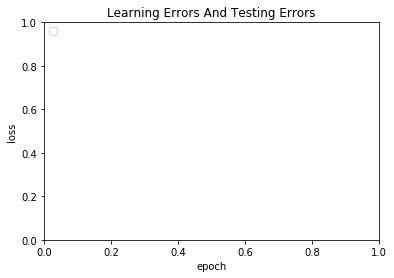

In [584]:
t_fig, t_ax = plt.subplots()
t_ax.plot()
plt.show()